In [ ]:
!pip install torch-geometric

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import requests

2023-06-01 18:11:47.360523: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 18:11:47.695215: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-01 18:11:47.695271: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-01 18:11:48.719140: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

### Collect dataset

In [4]:
url = 'http://api.scraperlink.com/investpy/?email=your@email.com&type=historical_data&product=cryptos&symbol=BTC&from_date=10/01/2013&to_date=2/1/2023'
response = requests.request('GET', url)
prices = response.json()['data']
data = pd.DataFrame(prices)

In [5]:
data.head()

,direction_color,rowDate,rowDateRaw,rowDateTimestamp,last_close,last_open,last_max,last_min,volume,volumeRaw,change_precent,last_closeRaw,last_openRaw,last_maxRaw,last_minRaw,change_precentRaw
0,greenFont,"Feb 01, 2023",1675209600,2023-02-01T00:00:00Z,"23,725.6","23,124.7","23,784.5","22,809.6",333.18K,333182,2.60,23725.58007812500000,23124.74023437500000,23784.51171875000000,22809.64843750000000,2.596756
1,greenFont,"Jan 31, 2023",1675123200,2023-01-31T00:00:00Z,"23,125.1","22,832.2","23,262.9","22,724.9",289.38K,289377,1.28,23125.07812500000000,22832.18750000000000,23262.93164062500000,22724.92187500000000,1.282797
2,redFont,"Jan 30, 2023",1675036800,2023-01-30T00:00:00Z,"22,832.2","23,746.0","23,794.0","22,560.0",339.62K,339618,-3.88,22832.18750000000000,23745.96289062500000,23793.99804687500000,22560.01171875000000,-3.877011
3,greenFont,"Jan 29, 2023",1674950400,2023-01-29T00:00:00Z,"23,753.1","23,023.5","23,952.9","22,973.3",320.86K,320863,3.15,23753.09765625000000,23023.52343750000000,23952.85937500000000,22973.33593750000000,3.149343
4,redFont,"Jan 28, 2023",1674864000,2023-01-28T00:00:00Z,"23,027.9","23,074.6","23,182.3","22,889.8",156.96K,156957,-0.20,23027.87109375000000,23074.59570312500000,23182.31054687500000,22889.75976562500000,-0.202494


In [6]:
prices = data[['last_close', 'last_open', 'last_max', 'last_min']].replace({',':''}, regex=True).astype(np.float64)
prices

,last_close,last_open,last_max,last_min
0,23725.6,23124.7,23784.5,22809.6
1,23125.1,22832.2,23262.9,22724.9
2,22832.2,23746.0,23794.0,22560.0
3,23753.1,23023.5,23952.9,22973.3
4,23027.9,23074.6,23182.3,22889.8
...,...,...,...,...
3406,136.7,136.8,138.0,135.3
3407,136.8,131.0,139.8,128.5
3408,131.0,123.0,132.0,120.1
3409,123.0,140.3,141.9,109.7


In [7]:
predicted_prices = prices['last_close'][1:]
data = prices.copy()[:-1]
data['target'] = np.int32( np.array(predicted_prices)>=data['last_close'] ) #whether price will go up or down
data

,last_close,last_open,last_max,last_min,target
0,23725.6,23124.7,23784.5,22809.6,0
1,23125.1,22832.2,23262.9,22724.9,0
2,22832.2,23746.0,23794.0,22560.0,1
3,23753.1,23023.5,23952.9,22973.3,0
4,23027.9,23074.6,23182.3,22889.8,1
...,...,...,...,...,...
3405,137.8,136.7,138.0,134.1,0
3406,136.7,136.8,138.0,135.3,1
3407,136.8,131.0,139.8,128.5,0
3408,131.0,123.0,132.0,120.1,0


In [57]:
import gudhi
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

class predictor:
    def __init__(self, data, k = 20, max_dim=2, threshold=3):
        self.max_dim = max_dim
        self.k = k
        self.threshold = threshold
        self.R = np.linspace(0, threshold, k)
        self.images = []


        # Define the model architecture
        model = tf.keras.Sequential([
            layers.Reshape((k, k, 1), input_shape=(k, k)),  # Reshape input to (20, 20, 1)
            layers.Conv2D(16, 3, activation='relu'),           # Convolutional layer with 16 filters
            layers.MaxPooling2D(2),                            # Max pooling layer
            layers.Flatten(),                                  # Flatten the output
            layers.Dense(32, activation='relu'),               # Dense layer with 32 units
            layers.Dense(1, activation='sigmoid')              # Output layer with sigmoid activation
        ])

        # Compile the model
        model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
        self.model = model

    def persistent_analysis(self, data):
        rips_complex = gudhi.RipsComplex(points=data)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=self.max_dim)
        diag = simplex_tree.compute_persistence()
        simplices = list(simplex_tree.get_simplices())
        simplices = [i for i in simplices if i[1]<self.threshold]
        simplices.sort(key=lambda x: x[1])
        simplices = simplices[len(data):]
        return simplices
    
    def analysis_to_image(self, simplices):
        i = 0
        image = np.zeros((len(self.R), self.k))
        for j in range(len(simplices)):
            if self.R[i+1]<simplices[j][1]:
                i+=1
            d = len( simplices[j][0] )
            for point in simplices[j][0]:
                image[i][point] += d
        return image
    
    def fit(self, data, epochs=5):
        X=[]
        k = self.k
        for i in range(k-1, len(data)):
            x = np.array( data.iloc[i-k+1:i+1, :4] )
            x -= np.min(x)
            x /= np.max(x)
            tmp = np.zeros((k,5))
            tmp[:,:-1] = x
            tmp[:,-1] = list(range(k))
            X.append( tmp )

        y = data.iloc[k-1:,-1]

        self.X = np.array(X)
        self.images += [self.analysis_to_image(self.persistent_analysis(x)) for x in X]
        self.model.fit( np.array(self.images), y, epochs=epochs)

    def predict(self, X):
        return self.model.predict(X)
    
    def evaluate(self, X, y):
        return self.model.evaluate(X,y)

    



        
        

model = predictor(data, k=20, max_dim=2, threshold=2)

In [58]:
model.fit(data, epochs = 10)

Epoch 1/10
106/106 [==============================] - 1s 4ms/step - loss: 0.6994 - accuracy: 0.5193
Epoch 2/10
106/106 [==============================] - 0s 3ms/step - loss: 0.6881 - accuracy: 0.5435
Epoch 3/10
106/106 [==============================] - 0s 3ms/step - loss: 0.6869 - accuracy: 0.5376
Epoch 4/10
106/106 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.5588
Epoch 5/10
106/106 [==============================] - 0s 3ms/step - loss: 0.6745 - accuracy: 0.5851
Epoch 6/10
106/106 [==============================] - 0s 4ms/step - loss: 0.6698 - accuracy: 0.5851
Epoch 7/10
106/106 [==============================] - 0s 3ms/step - loss: 0.6619 - accuracy: 0.5995
Epoch 8/10
106/106 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6211
Epoch 9/10
106/106 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6346
Epoch 10/10
106/106 [==============================] - 0s 4ms/step - loss: 0.6300 - accuracy: 0.6508

In [34]:
s = model.persistent_analysis(model.X[0])

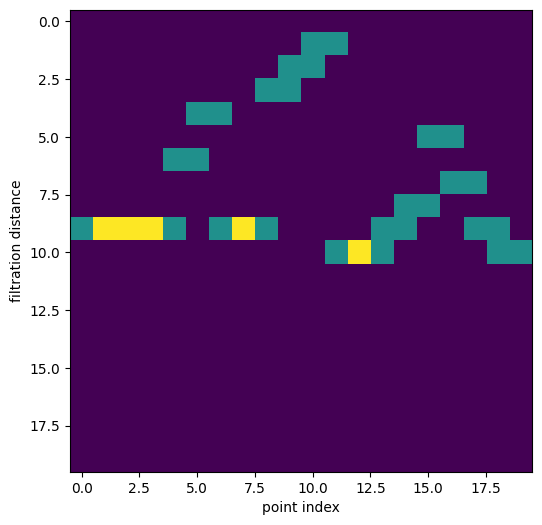

In [35]:
plt.figure(figsize= (6,6) )
plt.ylabel('filtration distance')
plt.xlabel('point index')
plt.imshow( model.analysis_to_image(s) )

In [26]:
model.R

array([0.        , 0.33333333, 0.66666667, 1.        , 1.33333333,
       1.66666667, 2.        , 2.33333333, 2.66666667, 3.        ])